<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Wage_range_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm
!pip install --upgrade lightgbm

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score

# טען את הדאטה
data = pd.read_csv('salaries.csv')
data = data.drop(columns=["work_year", "salary", "salary_currency"])

# זיהוי עמודות טקסטואליות
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# המרת עמודות לקטגוריות
for col in categorical_columns:
    data[col] = data[col].astype('category')

# בדיקה
print(data.dtypes)



experience_level      category
employment_type       category
job_title             category
salary_in_usd            int64
employee_residence    category
remote_ratio          category
company_location      category
company_size          category
dtype: object


In [92]:
unique_jobs = data['job_title'].nunique()  # מספר המשרות הייחודיות
unique_job_titles = data['job_title'].unique()  # רשימת המשרות הייחודיות

print(f"Number of unique job titles: {unique_jobs}")
print(f"Unique job titles: {unique_job_titles}")


Number of unique job titles: 318
Unique job titles: ['Cyber Security Consultant', 'Systems Engineer', 'DevSecOps Engineer', 'Consultant', 'Security Consultant', ..., 'Enterprise Security Engineer', 'Principal Cloud Security Engineer', 'Corporate Infrastructure Security Engineer', 'Lead Application Security Engineer', 'Concierge Security Engineer']
Length: 318
Categories (318, object): ['Account Executive', 'Application Security Analyst',
                           'Application Security Architect', 'Application Security Engineer', ...,
                           'Vulnerability Management Specialist', 'Vulnerability Manager', 'Vulnerability Researcher',
                           'Zero Trust Architect']


Distribution of Job Titles:
job_title
Security Engineer                         9250
Security Analyst                          2648
Software Engineer                         1207
Security Architect                        1036
Consultant                                 933
                                          ... 
Infosec Risk Manager                         1
Principal Security Architect                 1
Principal Product Manager                    1
Global Information Security Specialist       1
Enterprise Security Architect                1
Name: count, Length: 318, dtype: int64

Percentage of Job Titles:
job_title
Security Engineer                         28.189188
Security Analyst                           8.069726
Software Engineer                          3.678308
Security Architect                         3.157189
Consultant                                 2.843299
                                            ...    
Infosec Risk Manager                       0.003047
Princ

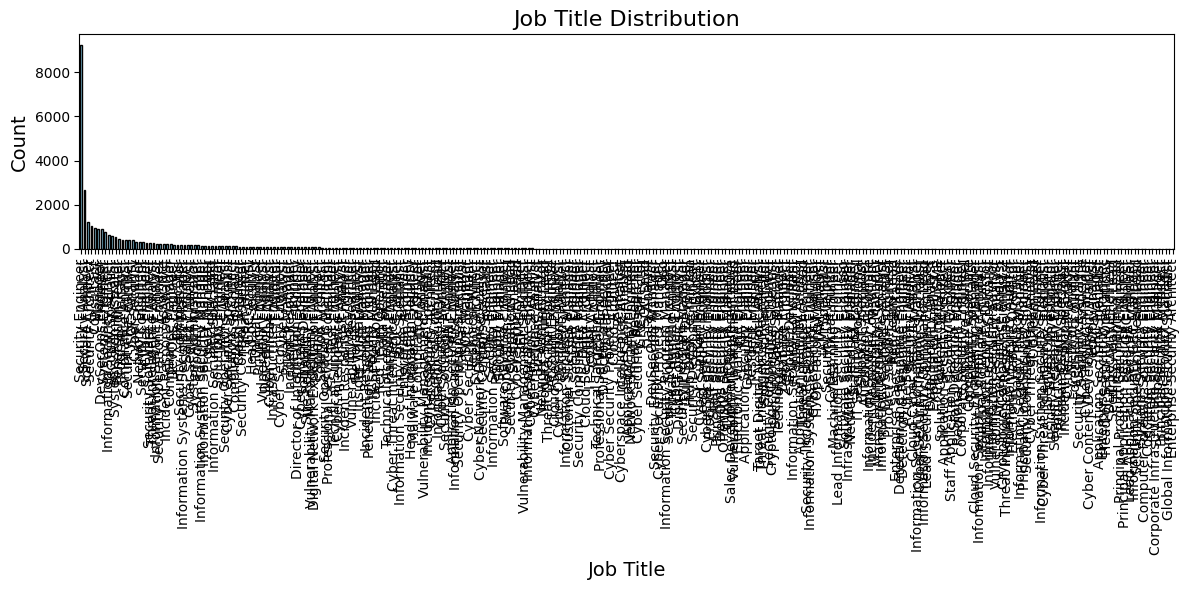


Imbalance Ratio (Max/Min): 9250.00


In [93]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the number of records for each job title
job_counts = data['job_title'].value_counts()

# Calculate the percentage of records for each job title
job_percentage = (job_counts / len(data)) * 100

# Display the distribution of job titles
print("Distribution of Job Titles:")
print(job_counts)

print("\nPercentage of Job Titles:")
print(job_percentage)

# Visualize the distribution
plt.figure(figsize=(12, 6))
job_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Job Title Distribution", fontsize=16)
plt.xlabel("Job Title", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Check for imbalance
imbalance_ratio = job_counts.max() / job_counts.min()
print(f"\nImbalance Ratio (Max/Min): {imbalance_ratio:.2f}")

if imbalance_ratio > 10:
    print("Warning: Significant imbalance detected!")
else:
    print("The data is relatively balanced.")


In [103]:
# קביעת חסם מינימלי
min_threshold = 50

# ספירת התפקידים
job_counts = data['job_title'].value_counts()

# סינון תפקידים מתחת לחסם
filtered_data = data[data['job_title'].isin(job_counts[job_counts >= min_threshold].index)]


# בדיקת התוצאה
print(f"Total records before filtering: {len(data)}")
print(f"Total records after filtering: {len(filtered_data)}")
print(f"Number of unique job titles before: {len(job_counts)}")
print(f"Number of unique job titles after: {filtered_data['job_title'].nunique()}")


Total records before filtering: 32814
Total records after filtering: 30124
Number of unique job titles before: 318
Number of unique job titles after: 86


In [ ]:

# Count the number of records for each job title
job_counts = filtered_data['job_title'].value_counts()

# Calculate the percentage of records for each job title
job_percentage = (job_counts / len(filtered_data)) * 100

# Display the distribution of job titles
print("Distribution of Job Titles:")
print(job_counts)

print("\nPercentage of Job Titles:")
print(job_percentage)

# Visualize the distribution
plt.figure(figsize=(12, 6))
job_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Job Title Distribution", fontsize=16)
plt.xlabel("Job Title", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Check for imbalance
imbalance_ratio = job_counts.max() / job_counts.min()
print(f"\nImbalance Ratio (Max/Min): {imbalance_ratio:.2f}")

if imbalance_ratio > 10:
    print("Warning: Significant imbalance detected!")
else:
    print("The data is relatively balanced.")


In [ ]:
# Visualize the top 20 job titles for a clearer view
plt.figure(figsize=(12, 6))
job_counts.head(20).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 20 Job Title Distribution", fontsize=16)
plt.xlabel("Job Title", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Till now- learned data

Now- try 3 algo: random forest, xgboost, lightgbm

In [133]:

# הפרדת משתנים תלויים ובלתי תלויים
X = data.drop(columns=['salary_in_usd'])  # הסרת עמודת המטרה
y = data['salary_in_usd']

# חלוקה לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fot rf and xgboost
# One-Hot Encoding למשתנים קטגוריאליים
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


Naive model

In [120]:
import numpy as np
from sklearn.metrics import mean_squared_error

# חישוב תחזית בסיסית
baseline_prediction = np.mean(y_train)

# חישוב RMSE למודל בסיסי
rmse_baseline = np.sqrt(mean_squared_error(y_test, [baseline_prediction] * len(y_test)))

print(f"Baseline RMSE: {rmse_baseline:.2f}")


Baseline RMSE: 63284.64


linear model

In [129]:
from sklearn.linear_model import LinearRegression
# התאמת מודל רגרסיה ליניארי
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# חיזוי על נתוני הבדיקה
y_pred_lr = lr_model.predict(X_test_encoded)

# הערכת ביצועי המודל
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr= np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"\nLinear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")



Linear Regression - MAE: 42679.79, RMSE: 55787.34


random forest:

In [81]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")


Random Forest - MAE: 41765.52, RMSE: 55255.55


xgboost

In [85]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


XGBoost - MAE: 41475.56, RMSE: 54665.37


In [89]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


XGBoost - MAE: 42152.98, RMSE: 55585.12


lgb

In [134]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# אימון המודל
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# חישוב MSE
mse = mean_squared_error(y_test, y_pred)

# חישוב RMSE ידנית
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[75]	training's rmse: 54380.6	valid_1's rmse: 54283.1
Mean Squared Error: 2946656412.27
Root Mean Squared Error: 54283.11


In [135]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 63,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.6,
    'verbose': -1
}

# אימון המודל
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# חישוב MSE
mse = mean_squared_error(y_test, y_pred)

# חישוב RMSE ידנית
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[36]	training's rmse: 54354.4	valid_1's rmse: 54189.5
Mean Squared Error: 2936500906.29
Root Mean Squared Error: 54189.49


Chosen

In [136]:
model.save_model('lightgbm_model.txt')


Similar results- now take only jobs with >= 50 entries

In [124]:

# הפרדת משתנים תלויים ובלתי תלויים
X = filtered_data.drop(columns=['salary_in_usd'])  # הסרת עמודת המטרה
y = filtered_data['salary_in_usd']

# חלוקה לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fot rf and xgboost
# One-Hot Encoding למשתנים קטגוריאליים
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


In [115]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
r2 = r2_score(y_test, y_pred_rf)
print(f"Explained Variance (R^2): {r2:.2f}")


Random Forest - MAE: 42060.22, RMSE: 55424.37
Explained Variance (R^2): 0.23


In [114]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)
print(f"Explained Variance (R^2): {r2:.2f}")


XGBoost - MAE: 41986.65, RMSE: 55327.50
Explained Variance (R^2): 0.24


In [113]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)
print(f"Explained Variance (R^2): {r2:.2f}")


XGBoost - MAE: 42332.03, RMSE: 56043.78
Explained Variance (R^2): 0.22


In [125]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# אימון המודל
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# חישוב MSE
mse = mean_squared_error(y_test, y_pred)

# חישוב RMSE ידנית
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance (R^2): {r2:.2f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[142]	training's rmse: 54362	valid_1's rmse: 54834.2
Mean Squared Error: 3006787157.72
Root Mean Squared Error: 54834.18
Explained Variance (R^2): 0.25


In [128]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# יצירת דאטה ל-LightGBM עם free_raw_data=False
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

test_data = lgb.Dataset(
    X_test,
    label=y_test,
    reference=train_data,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

# פונקציה להרצת ניסויים
def run_lgb_experiment(params_list, train_data, test_data, X_test, y_test):
    results = []
    for params in params_list:
        # אימון המודל
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=10)]
        )

        # חיזוי
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        # הערכת הביצועים
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # שמירת התוצאה
        results.append({
            'params': params,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })

    return results

# רשימת פרמטרים לניסוי
params_list = [
    {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': lr,
        'num_leaves': leaves,
        'min_data_in_leaf': min_data,
        'feature_fraction': feature_frac,
        'bagging_fraction': bagging_frac,
        'verbose': -1
    }
    for lr in [0.01, 0.05, 0.1]  # ניסוי עם Learning Rate משתנה
    for leaves in [15, 31, 63]  # מספר עלים
    for min_data in [20, 50, 100]  # מינימום דוגמאות בכל עלה
    for feature_frac in [0.6, 0.8, 1.0]  # אחוז פיצ'רים
    for bagging_frac in [0.6, 0.8, 1.0]  # אחוז דוגמאות
]

# הרצת הניסוי
results = run_lgb_experiment(params_list, train_data, test_data, X_test, y_test)

# הדפסת התוצאות הטובות ביותר
best_result = min(results, key=lambda x: x['rmse'])
print("Best Parameters:")
print(best_result['params'])
print(f"RMSE: {best_result['rmse']:.2f}, R^2: {best_result['r2']:.2f}")


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 54680.1	valid_1's rmse: 54967.2
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 54680.1	valid_1's rmse: 54967.2
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 54680.1	valid_1's rmse: 54967.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[615]	training's rmse: 54685.1	valid_1's rmse: 54974.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[615]	training's rmse: 54685.1	valid_1's rmse: 54974.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[615]	training's rmse: 54685.1	valid_1's rmse: 54974.2
Training until validation scores don't improve for 1

In [68]:
# חישוב MAE
mae = mean_absolute_error(y_test, y_pred)

# חישוב RMSE באופן ידני
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 41332.20272252852
Root Mean Squared Error: 54283.113509368915


In [69]:
# חישוב טווח השכר
salary_min = data['salary_in_usd'].min()
salary_max = data['salary_in_usd'].max()
salary_mean = data['salary_in_usd'].mean()

print(f"Minimum Salary: {salary_min}")
print(f"Maximum Salary: {salary_max}")
print(f"Mean Salary: {salary_mean}")


Minimum Salary: 15061
Maximum Salary: 720000
Mean Salary: 146426.01289083928


In [70]:
relative_rmse = (rmse / salary_mean) * 100
print(f"Relative RMSE: {relative_rmse:.2f}%")


Relative RMSE: 37.07%


In [71]:
from sklearn.metrics import mean_squared_error
import numpy as np

# חיזוי ממוצע השכר
baseline_pred = [salary_mean] * len(y_test)

# חישוב RMSE למודל הבסיסי
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f"Baseline RMSE: {baseline_rmse:.2f}")


Baseline RMSE: 62877.04


In [72]:
salary_std = data['salary_in_usd'].std()
print(f"Standard Deviation of Salary: {salary_std}")


Standard Deviation of Salary: 63675.99206590069


In [73]:
# תחזיות של המודל ונתוני אמת
predictions = pd.DataFrame({
    'job_title': X_test['job_title'],  # משרות בסט הבדיקה
    'actual_salary': y_test,          # שכר אמיתי
    'predicted_salary': y_pred        # תחזיות המודל
})

# חישוב שגיאות לפי משרה
results = []
for job in predictions['job_title'].unique():
    job_data = predictions[predictions['job_title'] == job]
    mse = mean_squared_error(job_data['actual_salary'], job_data['predicted_salary'])
    rmse = np.sqrt(mse)
    mean_actual = job_data['actual_salary'].mean()
    relative_rmse = (rmse / mean_actual) * 100  # RMSE יחסית לממוצע השכר

    results.append({
        'job_title': job,
        'rmse': rmse,
        'relative_rmse': relative_rmse,
        'mean_actual_salary': mean_actual,
        'count': len(job_data)
    })

# הפיכת התוצאות ל-DataFrame
results_df = pd.DataFrame(results)

# מיון לפי RMSE יחסית
results_df = results_df.sort_values(by='relative_rmse', ascending=False)

# הצגת תוצאות
print("Accuracy by Job Title:")
print(results_df)

# שמירת התוצאות לקובץ
results_df.to_csv("job_title_accuracy.csv", index=False)


Accuracy by Job Title:
                            job_title          rmse  relative_rmse  \
222      Cloud Cyber Security Analyst  34637.785007     209.951418   
173       Offensive Security Engineer  54465.880955     169.374882   
226            IT Security Specialist  41476.092859     165.904371   
76       Information Security Advisor  64637.244619     137.751731   
202              Help Desk Technician  72140.898097     133.594256   
..                                ...           ...            ...   
209  Cryptologic Computer Scientist 2   3940.898097       3.224958   
136                       QA Engineer   3859.101903       2.968540   
203         Cyber Security Consultant   2761.570196       2.945675   
89       Principal Security Architect   3322.619932       2.920985   
210          Russian OSINT Specialist    823.548861       0.507893   

     mean_actual_salary  count  
222             16498.0      1  
173             32157.0      2  
226             25000.0      1  
76  

In [74]:
# שימוש במודל שכבר אומן (להחליף ב-lightgbm או בכל מודל מאומן)
# לדוגמה:
# model = your_trained_model

# נתונים למשתמש חדש
new_user = pd.DataFrame({
    'experience_level': ['SE'],         # Senior level
    'employment_type': ['FT'],          # Full-time
    'employee_residence': ['US'],       # Residence in the US
    'company_location': ['US'],         # Company located in the US
    'company_size': ['L'],              # Large company
    'job_title': ['Data Scientist'],    # Job title
    'remote_ratio': [100]               # Fully remote
})

# עמודות קטגוריאליות
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# המרת עמודות לקטגוריה
for col in categorical_columns:
    if col in new_user.columns:
        new_user[col] = new_user[col].astype('category')

# התאמת עמודות למבנה סט האימון
for col in X_train.columns:
    if col not in new_user.columns:
        new_user[col] = 0  # הוספת עמודות חסרות

# סידור העמודות לפי סדר סט האימון
new_user = new_user[X_train.columns]

# חיזוי שכר (באמצעות מודל שאומן מראש)
predicted_salary = model.predict(new_user)[0]
print(f"Predicted Salary for the new user: ${predicted_salary:,.2f}")


Predicted Salary for the new user: $181,567.69


In [75]:
def categorize_experience(profile_text):
    """
    פונקציה שממפה קטגוריית ניסיון (EN, MI, SE, EX) על סמך שנות ניסיון מתוכן הטקסט.
    :param profile_text: טקסט פרופיל משתמש (string)
    :return: קטגוריית ניסיון (string)
    """
    import re

    # חיפוש שנות ניסיון בטקסט (למשל: '2 yrs', '10 years', '1 yr')
    experience_matches = re.findall(r"(\d+)\s*(?:yrs?|years?)", profile_text)

    # המרה למספרים של שנות ניסיון
    years_of_experience = sum(map(int, experience_matches))

    # קטגוריות ניסיון לפי מספר שנים
    if years_of_experience < 2:
        return 'EN'  # Entry Level
    elif 2 <= years_of_experience < 5:
        return 'MI'  # Mid Level
    elif 5 <= years_of_experience < 10:
        return 'SE'  # Senior Level
    else:
        return 'EX'  # Executive Level


# קריאה לדוגמה עם טקסט מהפרופיל שסיפקת
profile_text = """
Company       : Next Career
Duration      : 2 yrs 1 mo
--------------------------------------------------
  Job Title    : Career Coach
  Job Duration : 2024 - Present · 1 yr 1 mo
  --------------------------------------------------
  Job Title    : Owner
  Job Duration : 2023 - Present · 2 yrs 1 mo
  --------------------------------------------------
  Job Title     : Global Sourcing Manager
  Job Duration  : 2021 - 2023 · 2 yrs
  --------------------------------------------------
  Job Title     : Director Talent Acquisition
  Job Duration  : 2019 - 2021 · 2 yrs
  --------------------------------------------------
"""

# הפעלת הפונקציה
experience_category = categorize_experience(profile_text)
print(f"Experience Category: {experience_category}")


Experience Category: SE


In [76]:
!pip install pycountry

In [77]:
import pycountry
import re

def extract_job_details_with_iso(job_text):
    """
    חלץ פרטי משרה מתוך טקסט נתון והמר מיקום החברה ל-ISO 3166 Country Code באמצעות pycountry
    :param job_text: טקסט עם פרטי משרה
    :return: מילון עם פרטי המשרה, כולל ISO Country Code
    """

    # חילוץ כותרת המשרה
    job_title = re.search(r"Job Title\s*:\s*(.+)", job_text)
    job_title = job_title.group(1).strip() if job_title else "N/A"

    # חילוץ שם החברה
    company_name = re.search(r"Company\s*:\s*(.+)", job_text)
    company_name = company_name.group(1).strip() if company_name else "N/A"

    # חילוץ מיקום החברה
    company_location = re.search(r"Location\s*:\s*(.+)", job_text)
    company_location = company_location.group(1).strip() if company_location else "N/A"

    # המרת מיקום החברה ל-ISO 3166 Country Code
    country_code = "N/A"
    for country in pycountry.countries:
        if country.name in company_location:
            country_code = country.alpha_2
            break

    # עבודה מהבית: הגדרה לפי תנאים
    if "Remote" in job_text:
        remote_ratio = 100
    elif "Hybrid" in job_text:
        remote_ratio = 50
    elif "On-site" in job_text:
        remote_ratio = 0
    else:
        remote_ratio = "N/A"

    # הרכבת התוצאה
    return {
        "job_title": job_title,
        "company_name": company_name,
        "company_location": company_location,
        "iso_country_code": country_code,
        "remote_ratio": remote_ratio,
        "company_size": "N/A"  # יכול להיות מוגדר על פי מידע נוסף
    }


# קריאה לדוגמה עם הטקסט שסיפקת
job_text = """
Job Title    : Computer Vision Algorithm Engineer
Company      : Camtek
Location     :  Migdal HaEmek, North District, Israel
Description  : Camtek designs, develops, manufactures and markets technologically advanced, cost-effective systems and related software products that are used to enhance processes and yields serving the Advanced Packaging, Memory, CMOS Image Sensors, MEMS, RF, and other segments in the Semiconductors industry.
"""

# הפעלת הפונקציה
job_details = extract_job_details_with_iso(job_text)

# הצגת התוצאה
print(job_details)


{'job_title': 'Computer Vision Algorithm Engineer', 'company_name': 'Camtek', 'company_location': 'Migdal HaEmek, North District, Israel', 'iso_country_code': 'IL', 'remote_ratio': 'N/A', 'company_size': 'N/A'}


In [78]:
new_user = pd.DataFrame({
    'experience_level': [experience_category],         # Senior level
    'company_location': [job_details["iso_country_code"]],         # Company located in the US
    'job_title': [job_details["job_title"]],    # Job title
})



# עמודות קטגוריאליות
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# המרת עמודות לקטגוריה
for col in categorical_columns:
    if col in new_user.columns:
        new_user[col] = new_user[col].astype('category')

# ווידוא עמודות רלוונטיות לפי X_train
for col in X_train.columns:
    if col not in new_user.columns:
        # הוספת עמודה קטגוריאלית עם ערך ברירת מחדל 'Unknown'
        new_user[col] = "Unknown"
        new_user[col] = new_user[col].astype('category')
        new_user[col] = new_user[col].cat.set_categories(list(X_train[col].cat.categories) + ["Unknown"])

# סידור העמודות לפי הסדר של X_train
new_user = new_user[X_train.columns]

# חיזוי שכר
predicted_salary = model.predict(new_user)[0]
print(f"Predicted Salary for the new user: ${predicted_salary:,.2f}")


Predicted Salary for the new user: $80,230.53


In [79]:
new_user

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,SE,Unknown,Computer Vision Algorithm Engineer,Unknown,Unknown,IL,Unknown


In [80]:
def calculate_salary_range_dynamic(predicted_salary, match_percentage, base_lower_pct=0.9, base_upper_pct=1.0, step_pct=0.05):
    """
    חישוב טווח שכר דינמי המבוסס על רמות שונות של אחוז התאמה, עם ערכים נגזרים באחוזים מהשכר החזוי
    :param predicted_salary: שכר חזוי
    :param match_percentage: אחוז התאמה למשרה
    :param base_lower_pct: אחוז לתחתית הטווח הבסיסי (ברירת מחדל: 90% מהשכר החזוי)
    :param base_upper_pct: אחוז לחלק העליון של הטווח הבסיסי (ברירת מחדל: 100% מהשכר החזוי)
    :param step_pct: אחוז קפיצה לכל רמת התאמה (ברירת מחדל: 5%)
    :return: גבול תחתון ועליון לטווח השכר
    """
    # חישוב טווח בסיסי
    base_lower = predicted_salary * base_lower_pct
    base_upper = predicted_salary * base_upper_pct

    # חישוב גודל הקפיצה באחוזים
    step_size = predicted_salary * step_pct

    # קביעת מספר הצעדים מאחוז התאמה בסיסי (50%)
    steps = (match_percentage - 50) // 10  # כל 10% מייצגים צעד אחד

    # חישוב הטווח החדש
    lower_bound = base_lower + steps * step_size
    upper_bound = base_upper + steps * step_size

    return lower_bound, upper_bound


# דוגמה לשימוש
match_percentage = 85       # אחוז התאמה לדוגמה

# חישוב טווח השכר
lower_salary, upper_salary = calculate_salary_range_dynamic(predicted_salary, match_percentage)

# הצגת התוצאה
print(f"Predicted Salary: ${predicted_salary:,.2f}")
print(f"Salary Range (Match Percentage = {match_percentage}%): ${lower_salary:,.2f} - ${upper_salary:,.2f}")


Predicted Salary: $80,230.53
Salary Range (Match Percentage = 85%): $84,242.06 - $92,265.11
